### Refilter all. Aligning to genome makes no missing data. Adjust to remove loci private in each ssp/ploidy group too 

In [1]:
!source activate py36

/usr/bin/sh: line 0: source: activate: file not found


In [2]:
import sys

#sys.path.append('/home/faske/g/anaconda3/envs/py34/lib/python3.4/site-packages')
sys.path.append('/data/gpfs/assoc/parchmanlab/tfaske/anaconda3/envs/py36/lib/python3.6/site-packages')
sys.path.append("/data/gpfs/assoc/parchmanlab/tfaske/ipynb/include_utils")

import ipyparallel as ipp
import os, time
import include_utils as u
import pandas as pd
import numpy as np
import scipy as sp
import random
import numbers
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.cm as cm
import matplotlib.colors as mcolors
#import vcf
from sklearn import preprocessing
from subprocess import Popen, PIPE, call, check_output
import seaborn as sns
from IPython.display import FileLink
import urllib.request as urllib2
import dill
import traceback
from pandas import Series, DataFrame
import gzip
import warnings
warnings.filterwarnings('ignore',category=pd.io.pytables.PerformanceWarning)
%config InlineBackend.figure_format = 'retina'
from Bio import SeqIO
#import pysam
from collections import OrderedDict, namedtuple, Counter
import operator
import multiprocessing as mp
import shutil
import tempfile
#from ipyparallel import Client
import scandir
import glob
from Bio.SeqIO.QualityIO import FastqGeneralIterator
import pickle
import re
from itertools import chain
#import Levenshtein as lv

In [3]:
vcfutils = "vcfutils.pl"
vcftools = "vcftools"
bcftools = "bcftools"
bgzip = "bgzip"
tabix = "tabix"
java = "java"
plink = "plink --noweb"

In [4]:
analysis_dir = "/data/gpfs/assoc/denovo/tfaske/sagebrush/SNPcall/filtering"

In [5]:
cd $analysis_dir

/data/gpfs/assoc/denovo/tfaske/sagebrush/SNPcall/filtering


In [73]:
vcf_file = os.path.join(analysis_dir, "ARTR_chr.vcf.gz")
assert os.path.exists(vcf_file)
vcf_file

'/data/gpfs/assoc/denovo/tfaske/sagebrush/SNPcall/filtering/ARTR_chr.vcf.gz'

## keep only biallelic first

In [74]:
!$vcftools --remove-indels \
--min-alleles 2 \
--max-alleles 2 \
--remove-filtered-all \
--recode \
--recode-INFO-all \
--gzvcf \
$vcf_file \
--out $'ARTR_chr.biallelic'


VCFtools - 0.1.16
(C) Adam Auton and Anthony Marcketta 2009

Parameters as interpreted:
	--gzvcf /data/gpfs/assoc/denovo/tfaske/sagebrush/SNPcall/filtering/ARTR_chr.vcf.gz
	--recode-INFO-all
	--max-alleles 2
	--min-alleles 2
	--out ARTR_chr.biallelic
	--recode
	--remove-filtered-all
	--remove-indels

Using zlib version: 1.2.11
After filtering, kept 708 out of 708 Individuals
Outputting VCF file...
After filtering, kept 2766918 out of a possible 2774609 Sites
Run Time = 3749.00 seconds


In [223]:
#already done
#vcf_biallelic = "ARTR_chr.biallelic.recode.vcf" 
#vcf_biallelic_gz = "%s.gz" % vcf_biallelic
#!$bgzip -c $vcf_biallelic > {vcf_biallelic_gz}
#!$tabix {vcf_biallelic_gz}

vcf_biallelic_gz = os.path.join(analysis_dir, "ARTR_chr.biallelic.recode.vcf.gz")
assert os.path.exists(vcf_file)
vcf_biallelic_gz

'/data/gpfs/assoc/denovo/tfaske/sagebrush/SNPcall/filtering/ARTR_chr.biallelic.recode.vcf.gz'

## Remove by MAF, missing, and thin next

In [225]:
!$vcftools \
--max-missing 0.7 \
--maf 0.01 \
--thin 100 \
--remove-filtered-all \
--recode \
--recode-INFO-all \
--gzvcf \
$vcf_biallelic_gz \
--out $'ARTR_chr_miss70_thin100_MAF1'


VCFtools - 0.1.16
(C) Adam Auton and Anthony Marcketta 2009

Parameters as interpreted:
	--gzvcf /data/gpfs/assoc/denovo/tfaske/sagebrush/SNPcall/filtering/ARTR_chr.biallelic.recode.vcf.gz
	--recode-INFO-all
	--maf 0.01
	--thin 100
	--max-missing 0.7
	--out ARTR_chr_miss70_thin100_MAF1
	--recode
	--remove-filtered-all

Using zlib version: 1.2.11
After filtering, kept 708 out of 708 Individuals
Outputting VCF file...
After filtering, kept 470121 out of a possible 2766918 Sites
Run Time = 878.00 seconds


In [31]:
vcf_filtered = "ARTR_chr_miss70_thin100_MAF1.recode.vcf"
vcf_filtered_gz = "%s.gz" % vcf_filtered

In [227]:
!$bgzip -c $vcf_filtered > {vcf_filtered_gz}
!$tabix {vcf_filtered_gz}

# Calulate missing data and private alleles using vcfR


In [6]:
%load_ext rpy2.ipython

In [7]:
%%R
require(readr)
library(data.table)
require(MASS)
require(ggplot2)
library(vcfR)

source('/data/gpfs/home/tfaske/g/src/R/Imports.R')

setwd('/data/gpfs/assoc/denovo/tfaske/sagebrush/SNPcall/filtering/')

R[write to console]: Loading required package: readr

R[write to console]: Loading required package: MASS

R[write to console]: Loading required package: ggplot2

R[write to console]: 
   *****       ***   vcfR   ***       *****
   This is vcfR 1.8.0 
     browseVignettes('vcfR') # Documentation
     citation('vcfR') # Citation
   *****       *****      *****       *****




In [8]:
%%R
vcf <- read.vcfR("ARTR_chr_miss70_thin100_MAF1.recode.vcf", verbose = FALSE)

#get positions
chrom <- getCHROM(vcf)
pos <- getPOS(vcf)
pos_ID <- paste(chrom,pos,sep = ':')

In [12]:
%%R
#get pl 
dp <- extract.gt(vcf, element = 'DP')

In [13]:
%%R
## check out PL and pos_ID
print(length(pos_ID))
print(pos_ID[1:10])
dp[1:5,1:5]

[1] 470121
 [1] "CM042338.1:22493"  "CM042338.1:59115"  "CM042338.1:97078" 
 [4] "CM042338.1:106063" "CM042338.1:126072" "CM042338.1:128439"
 [7] "CM042338.1:129199" "CM042338.1:129763" "CM042338.1:130233"
[10] "CM042338.1:169173"
                  AT2_BB_10 AT2_BB_11 AT2_BB_12 AT2_BB_13 AT2_BB_14
CM042338.1_22493  "0"       "0"       "0"       "0"       "0"      
CM042338.1_59115  "3"       "0"       "0"       "0"       "0"      
CM042338.1_97078  "0"       "0"       "0"       "0"       "0"      
CM042338.1_106063 "0"       "0"       "0"       "0"       "0"      
CM042338.1_126072 "2"       "0"       "2"       "1"       "4"      


In [14]:
%%R
str(dp[1:5,1:5])

 chr [1:5, 1:5] "0" "3" "0" "0" "2" "0" "0" "0" "0" "0" "0" "0" "0" "0" "2" ...
 - attr(*, "dimnames")=List of 2
  ..$ : chr [1:5] "CM042338.1_22493" "CM042338.1_59115" "CM042338.1_97078" "CM042338.1_106063" ...
  ..$ : chr [1:5] "AT2_BB_10" "AT2_BB_11" "AT2_BB_12" "AT2_BB_13" ...


In [ ]:
%%R
pl_sum <- apply(pl,1:2, function(GP) sum(as.numeric(unlist(strsplit(as.character(GP),split = ',')))))

#### Calculate missing loci and individual

In [15]:
%%R
nloci <- ncol(dp)
nindv <- nrow(dp)
print(nloci)
print(nindv)

[1] 708
[1] 470121


In [ ]:
%%R


In [24]:
%%R
miss_loci <- apply(dp,1, function(d) length(which(d == "0"))/nloci)
#miss_loci <- apply(dp[,1:100],1, function(d) (length(which(d == "0"))/100))
print(summary(miss_loci))

    Min.  1st Qu.   Median     Mean  3rd Qu.     Max. 
0.001412 0.980226 0.998588 0.908238 0.998588 0.998588 


In [27]:
%%R
print(length(which(miss_loci <= .30)))
print(length(which(miss_loci <= .40)))
print(length(which(miss_loci <= .50)))
print(length(which(miss_loci <= .60)))
print(length(which(miss_loci <= .70)))

[1] 15690
[1] 24759
[1] 35149
[1] 46854
[1] 60896


In [29]:
%%R
keep_miss <- pos_ID[which(miss_loci <= .60)]
length(keep_miss)

In [35]:
%%R
keep_miss60_df <- data.frame(chrom=sapply(keep_miss,function(s) unlist(strsplit(as.character(s),':'))[1]),
                             pos=sapply(keep_miss,function(s) unlist(strsplit(as.character(s),':'))[2]))
print(head(keep_miss60_df))    
write.table(keep_miss60_df,'keep_miss60.txt',quote=F,row.names=F,col.names=F,sep='\t')

                        chrom     pos
CM042338.1:126072  CM042338.1  126072
CM042338.1:1342981 CM042338.1 1342981
CM042338.1:1496841 CM042338.1 1496841
CM042338.1:1744262 CM042338.1 1744262
CM042338.1:1942811 CM042338.1 1942811
CM042338.1:2385838 CM042338.1 2385838


In [36]:
!head keep_miss60.txt

CM042338.1	126072
CM042338.1	1342981
CM042338.1	1496841
CM042338.1	1744262
CM042338.1	1942811
CM042338.1	2385838
CM042338.1	3792582
CM042338.1	4255378
CM042338.1	5373930
CM042338.1	6087026


In [37]:
!$vcftools --gzvcf $vcf_filtered_gz \
--remove-filtered-all \
--recode \
--recode-INFO-all \
--positions {os.path.join(analysis_dir, "keep_miss60.txt")} \
--out {os.path.join(analysis_dir, "ARTR_chr_miss60_thin100_MAF1")}


VCFtools - 0.1.16
(C) Adam Auton and Anthony Marcketta 2009

Parameters as interpreted:
	--gzvcf ARTR_chr_miss70_thin100_MAF1.recode.vcf.gz
	--recode-INFO-all
	--out /data/gpfs/assoc/denovo/tfaske/sagebrush/SNPcall/filtering/ARTR_chr_miss60_thin100_MAF1
	--positions /data/gpfs/assoc/denovo/tfaske/sagebrush/SNPcall/filtering/keep_miss60.txt
	--recode
	--remove-filtered-all

Using zlib version: 1.2.11
After filtering, kept 708 out of 708 Individuals
Outputting VCF file...
After filtering, kept 46854 out of a possible 470121 Sites
Run Time = 76.00 seconds


In [38]:
vcf_filtered = "ARTR_chr_miss60_thin100_MAF1.recode.vcf"
vcf_filtered_gz = "%s.gz" % vcf_filtered
!$bgzip -c $vcf_filtered > {vcf_filtered_gz}
!$tabix {vcf_filtered_gz}

# Remove bad_indv

by do it by mean_depth cause no missing data 

In [40]:
!$vcftools --gzvcf {vcf_filtered_gz} \
--out {vcf_filtered_gz} \
--depth


VCFtools - 0.1.16
(C) Adam Auton and Anthony Marcketta 2009

Parameters as interpreted:
	--gzvcf ARTR_chr_miss60_thin100_MAF1.recode.vcf.gz
	--depth
	--out ARTR_chr_miss60_thin100_MAF1.recode.vcf.gz

Using zlib version: 1.2.11
After filtering, kept 708 out of 708 Individuals
Outputting Mean Depth by Individual
After filtering, kept 46854 out of a possible 46854 Sites
Run Time = 6.00 seconds


In [41]:
depth_file = vcf_filtered_gz + ".idepth"
depth_df = pd.read_csv(depth_file, sep="\t")
depth_df.head()

,INDV,N_SITES,MEAN_DEPTH
0,AT2_BB_10,46854,2.67627
1,AT2_BB_11,46854,1.75917
2,AT2_BB_12,46854,1.50275
3,AT2_BB_13,46854,2.21315
4,AT2_BB_14,46854,3.08396


In [42]:
depth_df.MEAN_DEPTH.describe()

count    708.000000
mean       2.050820
std        0.758901
min        0.004781
25%        1.546605
50%        1.983460
75%        2.606032
max        4.326910
Name: MEAN_DEPTH, dtype: float64

In [43]:
len(depth_df),len(depth_df[depth_df.MEAN_DEPTH <= .05]),len(depth_df[depth_df.MEAN_DEPTH <= .1]), len(depth_df[depth_df.MEAN_DEPTH <= .15])


(708, 6, 10, 12)

In [44]:
bad_indv = depth_df.INDV[depth_df.MEAN_DEPTH <= .1]

In [45]:
with open(os.path.join(analysis_dir, "bad_indv.txt"), "w") as o:
    o.write("INDV\n")
    for elem in bad_indv:
        o.write("%s\n" % elem)

In [46]:
!cat bad_indv.txt

INDV
AT2_LN_97
AT2_OC_1
AT2_SS_9
AT4_DS_9
AV2_TF_149
AV4_EW_5
AW4_FR_4
AW4_GB_3
AW4_JC_2
AW4_MK_232


In [47]:
!$vcftools --gzvcf $vcf_filtered_gz \
--remove-indels  \
--remove-filtered-all \
--recode \
--recode-INFO-all \
--remove {os.path.join(analysis_dir, "bad_indv.txt")} \
--out {os.path.join(analysis_dir, "snps_indv_removed")}


VCFtools - 0.1.16
(C) Adam Auton and Anthony Marcketta 2009

Parameters as interpreted:
	--gzvcf ARTR_chr_miss60_thin100_MAF1.recode.vcf.gz
	--remove /data/gpfs/assoc/denovo/tfaske/sagebrush/SNPcall/filtering/bad_indv.txt
	--recode-INFO-all
	--out /data/gpfs/assoc/denovo/tfaske/sagebrush/SNPcall/filtering/snps_indv_removed
	--recode
	--remove-filtered-all
	--remove-indels

Using zlib version: 1.2.11
Excluding individuals in 'exclude' list
After filtering, kept 698 out of 708 Individuals
Outputting VCF file...
After filtering, kept 46854 out of a possible 46854 Sites
Run Time = 65.00 seconds


In [48]:
vcf_bad_remove = os.path.join(analysis_dir, "snps_indv_removed.recode.vcf")
vcf_bad_remove_gz = vcf_bad_remove + ".gz"
!$bgzip -c {vcf_bad_remove} > {vcf_bad_remove_gz}
!$tabix {vcf_bad_remove_gz}

# Filter snps further 
this needs to be done after removing individuals


In [49]:
def get_vcf_stats(vcf_gz):
    
    stats = ['depth',
            'site-depth',
            'site-mean-depth',
            'site-quality',
            'missing-site',
            'freq',
            'counts',
            'hardy',
            'het']
    
    for stat in stats:
        !$vcftools --gzvcf $vcf_gz \
        --out $vcf_gz \
        {"--%s" % stat} 

In [50]:
get_vcf_stats(vcf_bad_remove_gz)


VCFtools - 0.1.16
(C) Adam Auton and Anthony Marcketta 2009

Parameters as interpreted:
	--gzvcf /data/gpfs/assoc/denovo/tfaske/sagebrush/SNPcall/filtering/snps_indv_removed.recode.vcf.gz
	--depth
	--out /data/gpfs/assoc/denovo/tfaske/sagebrush/SNPcall/filtering/snps_indv_removed.recode.vcf.gz

Using zlib version: 1.2.11
After filtering, kept 698 out of 698 Individuals
Outputting Mean Depth by Individual
After filtering, kept 46854 out of a possible 46854 Sites
Run Time = 6.00 seconds

VCFtools - 0.1.16
(C) Adam Auton and Anthony Marcketta 2009

Parameters as interpreted:
	--gzvcf /data/gpfs/assoc/denovo/tfaske/sagebrush/SNPcall/filtering/snps_indv_removed.recode.vcf.gz
	--out /data/gpfs/assoc/denovo/tfaske/sagebrush/SNPcall/filtering/snps_indv_removed.recode.vcf.gz
	--site-depth

Using zlib version: 1.2.11
After filtering, kept 698 out of 698 Individuals
Outputting Depth for Each Site
After filtering, kept 46854 out of a possible 46854 Sites
Run Time = 6.00 seconds

VCFtools - 0.1.16


VCFtools - 0.1.16
(C) Adam Auton and Anthony Marcketta 2009

Parameters as interpreted:
	--gzvcf /data/gpfs/assoc/denovo/tfaske/sagebrush/SNPcall/filtering/snps_indv_removed.recode.vcf.gz
	--hardy
	--out /data/gpfs/assoc/denovo/tfaske/sagebrush/SNPcall/filtering/snps_indv_removed.recode.vcf.gz

Using zlib version: 1.2.11
After filtering, kept 698 out of 698 Individuals
Outputting HWE statistics (but only for biallelic loci)
After filtering, kept 46854 out of a possible 46854 Sites
Run Time = 7.00 seconds

VCFtools - 0.1.16
(C) Adam Auton and Anthony Marcketta 2009

Parameters as interpreted:
	--gzvcf /data/gpfs/assoc/denovo/tfaske/sagebrush/SNPcall/filtering/snps_indv_removed.recode.vcf.gz
	--het
	--out /data/gpfs/assoc/denovo/tfaske/sagebrush/SNPcall/filtering/snps_indv_removed.recode.vcf.gz

Using zlib version: 1.2.11
After filtering, kept 698 out of 698 Individuals
Outputting Individual Heterozygosity
After filtering, kept 46854 out of a possible 46854 Sites
Run Time = 5.00 seconds

In [51]:
#pd.set_option('display.max_columns', 100)

def get_MAF(row):
    try:
        return np.min([row.A1_freq, row.A2_freq])
    except:
        print(row)
        
def get_correction(n):
    #for finite sample size
    return (2*n)/(2*n-1)

def calculate_Fis(vals):
    try:
        data = [float(x) for x in vals.split("/")]
        assert len(data) == 3
        num_individuals = np.sum(data)
        total_alleles = 2*num_individuals
        a1_count = 2*data[0]
        a2_count = 2*data[2]
        het_count = data[1]
        a1_count += het_count
        a2_count += het_count
        a1_freq = a1_count/total_alleles
        a2_freq = a2_count/total_alleles
        assert a1_freq + a2_freq == 1.0
        He = 2 * a1_freq * a2_freq * get_correction(num_individuals)
        Ho = het_count/num_individuals
        Fis = 1 - (Ho/He)
        return Fis
    except:
        return -9

def combine_vcf_stats(filedir, prefix):
    
    hardy_files = !ls {filedir}/{prefix}.hwe
    hardy = pd.read_csv(hardy_files[0], sep="\t")

    hardy.columns = ['CHROM', 'POS', 'OBS(HOM1/HET/HOM2)', 'E(HOM1/HET/HOM2)', 'ChiSq_HWE',
       'P_HWE', 'P_HET_DEFICIT', 'P_HET_EXCESS']
    hardy.index = hardy.apply(lambda x: "%s-%d" % (x.CHROM, x.POS), axis=1)
    
    loci_files = !ls {filedir}/{prefix}.l* | grep -v log
    loci_df = pd.concat([pd.read_csv(x, sep="\t", skiprows=0) for x in loci_files], axis=1)
    chrom_pos = loci_df.ix[:,0:2]
    
    frq_files = !ls {filedir}/{prefix}.frq* | grep -v count
    frq_data = []
    h = open(frq_files[0])
    header = h.readline().strip().split()
    for line in h:
        frq_data.append(line.strip().split('\t'))

    header = ['CHROM', 'POS', 'N_ALLELES', 'N_CHR', 'A1_FREQ', "A2_FREQ"]
    frq_df = pd.DataFrame(frq_data)
    print(frq_df.columns)
    #frq_df = frq_df.drop([6,7],axis=1)
    frq_df.columns = header
    frq_df.index = frq_df.apply(lambda x: "%s-%s" % (x.CHROM, x.POS), axis=1)
    
    loci_df = loci_df.drop(['CHROM','CHR','POS'], axis=1)
    loci_df = pd.concat([chrom_pos, loci_df], axis=1)
    loci_df.index = loci_df.apply(lambda x: "%s-%d" % (x.CHROM, x.POS), axis=1)
    
    loci_df = pd.concat([loci_df, frq_df, hardy], axis=1)
    loci_df["A1_allele"] = loci_df.apply(lambda row: row.A1_FREQ.split(":")[0], axis=1)
    loci_df["A2_allele"] = loci_df.apply(lambda row: row.A2_FREQ.split(":")[0], axis=1)
    
    loci_df["A1_freq"] = loci_df.apply(lambda row: float(row.A1_FREQ.split(":")[1]), axis=1)
    loci_df["A2_freq"] = loci_df.apply(lambda row: float(row.A2_FREQ.split(":")[1]), axis=1)
    
    loci_df['MAF'] = loci_df.apply(get_MAF, axis=1)
    loci_df = loci_df.drop(['CHROM', 'POS'], axis=1)
    
    loci_df['Fis'] = loci_df['OBS(HOM1/HET/HOM2)'].apply(calculate_Fis)
    
    return loci_df, frq_df, hardy

In [52]:
vcf_bad_remove_gz

'/data/gpfs/assoc/denovo/tfaske/sagebrush/SNPcall/filtering/snps_indv_removed.recode.vcf.gz'

In [53]:
loci_df, frq_df, hardy = combine_vcf_stats(analysis_dir,'snps_indv_removed.recode.vcf.gz')

/data/gpfs/assoc/parchmanlab/tfaske/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:45: FutureWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ix-indexer-is-deprecated
/data/gpfs/assoc/parchmanlab/tfaske/anaconda3/envs/py36/lib/python3.6/site-packages/pandas/core/indexing.py:822: FutureWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ix-indexer-is-deprecated
  retval = getattr(retval, self.name)._getitem_axis(key, axis=i)


RangeIndex(start=0, stop=6, step=1)


In [54]:
loci_df

,SUM_DEPTH,SUMSQ_DEPTH,MEAN_DEPTH,VAR_DEPTH,N_DATA,N_GENOTYPE_FILTERED,N_MISS,F_MISS,QUAL,N_ALLELES,...,ChiSq_HWE,P_HWE,P_HET_DEFICIT,P_HET_EXCESS,A1_allele,A2_allele,A1_freq,A2_freq,MAF,Fis
CM042338.1-126072,555,1601,0.795129,1.66385,1396,0,0,0,999.0,2,...,61.682280,2.580264e-09,2.580264e-09,1.000000,C,G,0.933381,0.066619,0.066619,0.297774
CM042338.1-1342981,1128,4994,1.616050,4.54964,1396,0,0,0,999.0,2,...,9.918258,2.855945e-03,2.292476e-03,0.999105,G,A,0.866762,0.133238,0.133238,0.119835
CM042338.1-1496841,2066,19146,2.959890,18.69570,1396,0,0,0,999.0,2,...,0.082348,1.000000e+00,1.000000e+00,0.926811,G,C,0.989255,0.010745,0.010745,-0.010138
CM042338.1-1744262,1081,4957,1.548710,4.70996,1396,0,0,0,999.0,2,...,0.119097,1.000000e+00,1.000000e+00,0.894945,C,T,0.987106,0.012894,0.012894,-0.012337
CM042338.1-1942811,1673,14005,2.396850,14.34010,1396,0,0,0,999.0,2,...,0.697515,6.113742e-01,8.618386e-01,0.300844,G,A,0.918338,0.081662,0.081662,-0.030873
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
CM042346.1-338104939,1753,8185,2.511460,5.42670,1396,0,0,0,999.0,2,...,0.132891,1.000000e+00,1.000000e+00,0.883255,C,A,0.986390,0.013610,0.013610,-0.013072
CM042346.1-338112942,2307,21957,3.305160,20.56240,1396,0,0,0,999.0,2,...,0.106078,1.000000e+00,1.000000e+00,0.906115,T,C,0.987822,0.012178,0.012178,-0.011603
CM042346.1-338202655,1578,6784,2.260740,4.61484,1396,0,0,0,999.0,2,...,0.119097,1.000000e+00,1.000000e+00,0.894945,T,G,0.987106,0.012894,0.012894,-0.012337
CM042346.1-338204118,1710,11438,2.449860,10.39990,1396,0,0,0,999.0,2,...,1.003578,1.000000e+00,1.000000e+00,0.387583,C,T,0.963467,0.036533,0.036533,-0.037175


In [55]:
frq_df

,CHROM,POS,N_ALLELES,N_CHR,A1_FREQ,A2_FREQ
CM042338.1-126072,CM042338.1,126072,2,1396,C:0.933381,G:0.0666189
CM042338.1-1342981,CM042338.1,1342981,2,1396,G:0.866762,A:0.133238
CM042338.1-1496841,CM042338.1,1496841,2,1396,G:0.989255,C:0.010745
CM042338.1-1744262,CM042338.1,1744262,2,1396,C:0.987106,T:0.012894
CM042338.1-1942811,CM042338.1,1942811,2,1396,G:0.918338,A:0.0816619
...,...,...,...,...,...,...
CM042346.1-338104939,CM042346.1,338104939,2,1396,C:0.98639,A:0.0136103
CM042346.1-338112942,CM042346.1,338112942,2,1396,T:0.987822,C:0.0121777
CM042346.1-338202655,CM042346.1,338202655,2,1396,T:0.987106,G:0.012894
CM042346.1-338204118,CM042346.1,338204118,2,1396,C:0.963467,T:0.036533


In [56]:
hardy

,CHROM,POS,OBS(HOM1/HET/HOM2),E(HOM1/HET/HOM2),ChiSq_HWE,P_HWE,P_HET_DEFICIT,P_HET_EXCESS
CM042338.1-126072,CM042338.1,126072,621/61/16,608.10/86.80/3.10,61.682280,2.580264e-09,2.580264e-09,1.000000
CM042338.1-1342981,CM042338.1,1342981,534/142/22,524.39/161.22/12.39,9.918258,2.855945e-03,2.292476e-03,0.999105
CM042338.1-1496841,CM042338.1,1496841,683/15/0,683.08/14.84/0.08,0.082348,1.000000e+00,1.000000e+00,0.926811
CM042338.1-1744262,CM042338.1,1744262,680/18/0,680.12/17.77/0.12,0.119097,1.000000e+00,1.000000e+00,0.894945
CM042338.1-1942811,CM042338.1,1942811,587/108/3,588.65/104.69/4.65,0.697515,6.113742e-01,8.618386e-01,0.300844
...,...,...,...,...,...,...,...,...
CM042346.1-338104939,CM042346.1,338104939,679/19/0,679.13/18.74/0.13,0.132891,1.000000e+00,1.000000e+00,0.883255
CM042346.1-338112942,CM042346.1,338112942,681/17/0,681.10/16.79/0.10,0.106078,1.000000e+00,1.000000e+00,0.906115
CM042346.1-338202655,CM042346.1,338202655,680/18/0,680.12/17.77/0.12,0.119097,1.000000e+00,1.000000e+00,0.894945
CM042346.1-338204118,CM042346.1,338204118,647/51/0,647.93/49.14/0.93,1.003578,1.000000e+00,1.000000e+00,0.387583


In [57]:
loci_out = os.path.join(analysis_dir,'loci_out.csv')
frq_out = os.path.join(analysis_dir,'frq_out.csv')
hardy_out = os.path.join(analysis_dir,'hardy_out.csv')

loci_df.to_csv(path_or_buf=loci_out)
frq_df.to_csv(path_or_buf=frq_out)
hardy.to_csv(path_or_buf=hardy_out)


In [58]:
loci_df.SUM_DEPTH.describe()

count     46854.000000
mean       1451.569407
std        1801.784653
min         418.000000
25%         819.000000
50%        1152.000000
75%        1711.000000
max      163984.000000
Name: SUM_DEPTH, dtype: float64

In [59]:
loci_df.MEAN_DEPTH.describe()

count    46854.000000
mean         2.079612
std          2.581353
min          0.598854
25%          1.173350
50%          1.650430
75%          2.451290
max        234.934000
Name: MEAN_DEPTH, dtype: float64

In [60]:
loci_df.QUAL.describe()

count    46854.000000
mean       995.497164
std         55.662527
min         30.374800
25%        999.000000
50%        999.000000
75%        999.000000
max        999.000000
Name: QUAL, dtype: float64

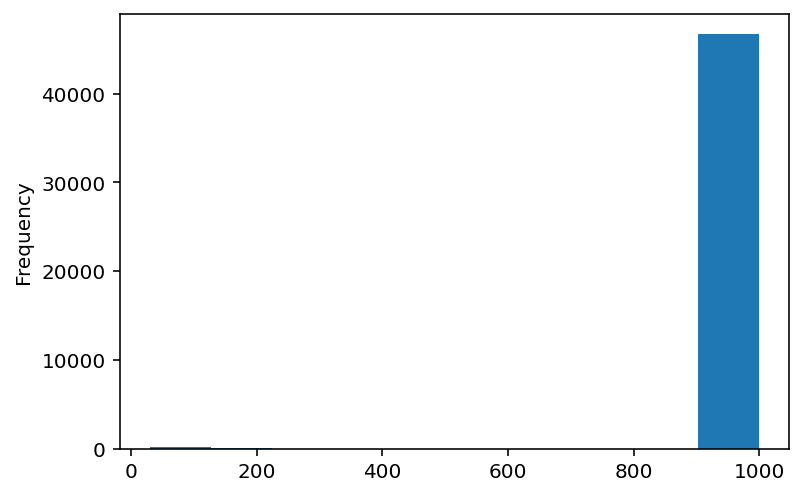

In [61]:
loci_df.QUAL.plot(kind="hist");

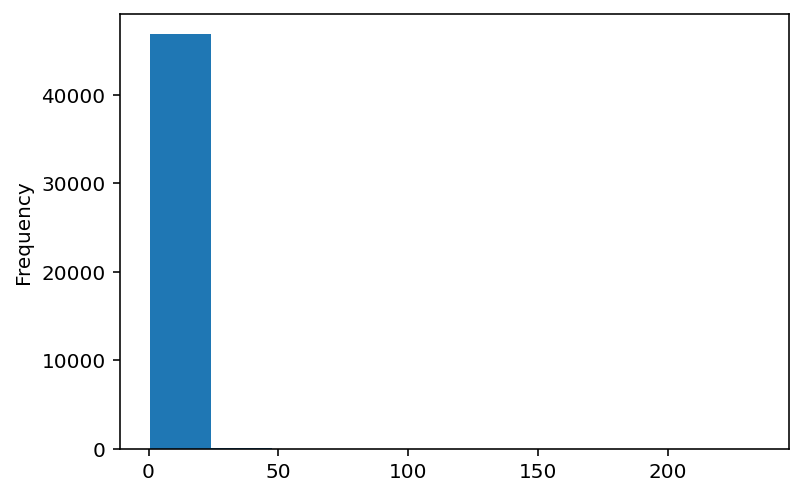

In [62]:
loci_df.MEAN_DEPTH.plot(kind="hist");

In [63]:
len(loci_df[loci_df.Fis == -9])

0

In [64]:
len(loci_df[loci_df.SUM_DEPTH <5000]),len(loci_df[loci_df.SUM_DEPTH >=500])

(46363, 46491)

In [152]:
len(loci_df[loci_df.MEAN_DEPTH > 25 ]),len(loci_df[loci_df.MEAN_DEPTH >= 2])

(21, 17278)

In [143]:
len(loci_df[loci_df.QUAL >= 20]) - len(loci_df[loci_df.QUAL >= 30])

0

In [144]:
len(loci_df[loci_df.QUAL >  20]), len(loci_df[loci_df.QUAL > 50]), len(loci_df[loci_df.QUAL > 100])

(46854, 46848, 46799)

In [145]:
 len(loci_df[loci_df.Fis >= -0.5]), len(loci_df[loci_df.MAF < 0.01])

(46726, 0)

In [153]:
def filter_snps(df, imputed=False):
    if imputed:
        return df[(df.MAF >= 0.01) &  
                  (df.Fis > -0.5)]
    else:
        return df[(df.MEAN_DEPTH >= 2) & 
                  (df.MEAN_DEPTH < 25) & 
                  (df.QUAL >= 100) & 
                  (df.MAF >= 0.01) &
                  (df.Fis >= -0.5)]

In [154]:
#42513 with df.Fis >= -0.5
#42688 without 
loci_stage1 = filter_snps(loci_df)
loci_stage1.shape

(17201, 25)

In [155]:
with open(os.path.join(analysis_dir, "stage1_positions.txt"), "w") as o:
    for elem in loci_stage1.index:
        o.write("%s\n" % "\t".join(elem.split("-")))

In [156]:
!$vcftools --gzvcf $vcf_bad_remove_gz \
--remove-indels  \
--remove-filtered-all \
--recode \
--recode-INFO-all \
--positions {os.path.join(analysis_dir, "stage1_positions.txt")} \
--out {os.path.join(analysis_dir, "good_snps")}


VCFtools - 0.1.16
(C) Adam Auton and Anthony Marcketta 2009

Parameters as interpreted:
	--gzvcf /data/gpfs/assoc/denovo/tfaske/sagebrush/SNPcall/filtering/snps_indv_removed.recode.vcf.gz
	--recode-INFO-all
	--out /data/gpfs/assoc/denovo/tfaske/sagebrush/SNPcall/filtering/good_snps
	--positions /data/gpfs/assoc/denovo/tfaske/sagebrush/SNPcall/filtering/stage1_positions.txt
	--recode
	--remove-filtered-all
	--remove-indels

Using zlib version: 1.2.11
After filtering, kept 698 out of 698 Individuals
Outputting VCF file...
After filtering, kept 17201 out of a possible 46854 Sites
Run Time = 25.00 seconds


In [157]:
snps = os.path.join(analysis_dir, "good_snps.recode.vcf")
snps_gz = snps + ".gz"
!$bgzip -c {snps} > {snps_gz}
!$tabix {snps_gz}

## recalculate missing data (loci / indv) & remove alleles not present in one ssp_ploidy group

In [158]:
%%R
vcf <- read.vcfR("good_snps.recode.vcf", verbose = FALSE)

#get positions
chrom <- getCHROM(vcf)
pos <- getPOS(vcf)
pos_ID <- paste(chrom,pos,sep = ':')

In [159]:
%%R
#get DP 
dp <- extract.gt(vcf, element = 'DP')

In [160]:
%%R
## check out PL and pos_ID
print(length(pos_ID))
print(pos_ID[1:10])
dp[1:5,1:5]

[1] 17201
 [1] "CM042338.1:1496841" "CM042338.1:1942811" "CM042338.1:6353755"
 [4] "CM042338.1:7214312" "CM042338.1:8063221" "CM042338.1:8177835"
 [7] "CM042338.1:8530959" "CM042338.1:8548932" "CM042338.1:8655617"
[10] "CM042338.1:8690402"
                   AT2_BB_10 AT2_BB_11 AT2_BB_12 AT2_BB_13 AT2_BB_14
CM042338.1_1496841 "0"       "1"       "3"       "6"       "8"      
CM042338.1_1942811 "0"       "0"       "0"       "0"       "9"      
CM042338.1_6353755 "7"       "3"       "5"       "5"       "6"      
CM042338.1_7214312 "5"       "3"       "0"       "0"       "0"      
CM042338.1_8063221 "3"       "3"       "0"       "1"       "8"      


In [161]:
%%R
ID <- colnames(dp)
ssp_ploid <- as.character(sapply(ID,function(s) unlist(strsplit(as.character(s),'_'))[1]))
ploidy <- sapply(ssp_ploid,function(s) gsub('(\\D)','',s,perl=TRUE))
print(length(ID))
print(ID[1:10])
print(ssp_ploid[1:10])
print(ploidy[1:10])

[1] 698
 [1] "AT2_BB_10" "AT2_BB_11" "AT2_BB_12" "AT2_BB_13" "AT2_BB_14" "AT2_BB_15"
 [7] "AT2_BB_16" "AT2_BB_17" "AT2_BB_1"  "AT2_BB_2" 
 [1] "AT2" "AT2" "AT2" "AT2" "AT2" "AT2" "AT2" "AT2" "AT2" "AT2"
AT2 AT2 AT2 AT2 AT2 AT2 AT2 AT2 AT2 AT2 
"2" "2" "2" "2" "2" "2" "2" "2" "2" "2" 


#### Calculate missing loci and individual

In [162]:
%%R
nindv <- ncol(dp)
nloci <- nrow(dp)
print(nloci)
print(nindv)

[1] 17201
[1] 698


In [163]:
%%R
miss_loci <- apply(dp,1, function(d) length(which(d == "0"))/nindv)
#miss_loci <- apply(dp[,1:100],1, function(d) (length(which(d == "0"))/100))
print(length(miss_loci))
print(summary(miss_loci))

[1] 17201
    Min.  1st Qu.   Median     Mean  3rd Qu.     Max. 
0.001433 0.128940 0.196275 0.207378 0.270774 0.590258 


In [168]:
%%R
#calculaate missing within each spp_ploid (hard code it)

#subset dp
dp_AT2 <- dp[,which(ssp_ploid=='AT2')]
dp_AT4 <- dp[,which(ssp_ploid=='AT4')]
dp_AV2 <- dp[,which(ssp_ploid=='AV2')]
dp_AV4 <- dp[,which(ssp_ploid=='AV4')]
dp_AW4 <- dp[,which(ssp_ploid=='AW4')]

#calc miss
miss_loci_AT2 <- apply(dp_AT2,1, function(d) length(which(d == "0"))/nindv)
print(summary(miss_loci_AT2))
                       
miss_loci_AT4 <- apply(dp_AT4,1, function(d) length(which(d == "0"))/nindv)
print(summary(miss_loci_AT4))
                       
miss_loci_AV2 <- apply(dp_AV2,1, function(d) length(which(d == "0"))/nindv)
print(summary(miss_loci_AV2))                       
                       
miss_loci_AV4 <- apply(dp_AV4,1, function(d) length(which(d == "0"))/nindv)
print(summary(miss_loci_AV4))                       
                       
miss_loci_AW4 <- apply(dp_AW4,1, function(d) length(which(d == "0"))/nindv)
print(summary(miss_loci_AW4))                       

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
0.00000 0.04298 0.06447 0.07052 0.08883 0.29943 
    Min.  1st Qu.   Median     Mean  3rd Qu.     Max. 
0.000000 0.002865 0.005731 0.006708 0.008596 0.037249 
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
0.00000 0.03582 0.05587 0.06533 0.08023 0.24212 
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
0.00000 0.01146 0.01862 0.02178 0.02865 0.10602 
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
0.00000 0.01862 0.03438 0.04303 0.05731 0.27364 


In [169]:
%%R
#calculaate missing within each ploidy

#subset dp
dp2 <- dp[,which(ploidy=='2')]
dp4 <- dp[,which(ploidy=='4')]

#calc miss
miss_loci_2 <- apply(dp2,1, function(d) length(which(d == "0"))/nloci)
print(summary(miss_loci_2))
                       
miss_loci_4 <- apply(dp4,1, function(d) length(which(d == "0"))/nloci)
print(summary(miss_loci_4))

    Min.  1st Qu.   Median     Mean  3rd Qu.     Max. 
0.000000 0.003488 0.005232 0.005513 0.007093 0.021278 
    Min.  1st Qu.   Median     Mean  3rd Qu.     Max. 
0.000000 0.001453 0.002500 0.002902 0.003779 0.016743 


### all groups have v little missing data, remove none

### Miss indv!

In [170]:
%%R
nloci <- nrow(dp)
#print(nloci)

miss_indv <- apply(dp,2, function(d) length(which(d == "0"))/nloci)
print(length(miss_indv))
print(summary(miss_indv))

[1] 698
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
 0.0611  0.1358  0.1853  0.2074  0.2507  0.8839 


In [171]:
%%R
for (perc in seq(.1,.9,by=.1)){
    print(paste0('number of individuals with greater than ',perc*100,'% missing data.....  ',
                 length(which(miss_indv >= perc))))
}

[1] "number of individuals with greater than 10% missing data.....  656"
[1] "number of individuals with greater than 20% missing data.....  314"
[1] "number of individuals with greater than 30% missing data.....  99"
[1] "number of individuals with greater than 40% missing data.....  27"
[1] "number of individuals with greater than 50% missing data.....  12"
[1] "number of individuals with greater than 60% missing data.....  8"
[1] "number of individuals with greater than 70% missing data.....  6"
[1] "number of individuals with greater than 80% missing data.....  2"
[1] "number of individuals with greater than 90% missing data.....  0"


In [172]:
%%R
miss60_indv_df <- data.frame(INDV=ID[which(miss_indv >= .60)])
miss60_indv_df
write.table(miss60_indv_df,'miss60_indv.txt',quote=F,row.names=F,col.names=T)

### use vcftools to remove individuals and loci based off above parameters

In [173]:
!$vcftools --gzvcf $snps_gz \
--remove-filtered-all \
--recode \
--recode-INFO-all \
--remove {os.path.join(analysis_dir, "miss60_indv.txt")} \
--out {os.path.join(analysis_dir, "final_snps")}


VCFtools - 0.1.16
(C) Adam Auton and Anthony Marcketta 2009

Parameters as interpreted:
	--gzvcf /data/gpfs/assoc/denovo/tfaske/sagebrush/SNPcall/filtering/good_snps.recode.vcf.gz
	--remove /data/gpfs/assoc/denovo/tfaske/sagebrush/SNPcall/filtering/miss60_indv.txt
	--recode-INFO-all
	--out /data/gpfs/assoc/denovo/tfaske/sagebrush/SNPcall/filtering/final_snps
	--recode
	--remove-filtered-all

Using zlib version: 1.2.11
Excluding individuals in 'exclude' list
After filtering, kept 690 out of 698 Individuals
Outputting VCF file...
After filtering, kept 17201 out of a possible 17201 Sites
Run Time = 23.00 seconds


In [174]:
final_snps = os.path.join(analysis_dir, "final_snps.recode.vcf")
final_snps_gz = final_snps + ".gz"
!$bgzip -c {final_snps} > {final_snps_gz}
!$tabix {final_snps_gz}

# Make 012

In [175]:
f = os.path.join(analysis_dir, "final_snps.recode.vcf")
!$vcftools --gzvcf {f} \
--out {f} \
--012


VCFtools - 0.1.16
(C) Adam Auton and Anthony Marcketta 2009

Parameters as interpreted:
	--gzvcf /data/gpfs/assoc/denovo/tfaske/sagebrush/SNPcall/filtering/final_snps.recode.vcf
	--012
	--out /data/gpfs/assoc/denovo/tfaske/sagebrush/SNPcall/filtering/final_snps.recode.vcf

Using zlib version: 1.2.11
After filtering, kept 690 out of 690 Individuals
Writing 012 matrix files ... Done.
After filtering, kept 17201 out of a possible 17201 Sites
Run Time = 3.00 seconds


# Get coverage per individual

In [176]:
f = os.path.join(analysis_dir, "final_snps.recode.vcf")
!$vcftools --gzvcf {f} \
--out {f} \
--depth


VCFtools - 0.1.16
(C) Adam Auton and Anthony Marcketta 2009

Parameters as interpreted:
	--gzvcf /data/gpfs/assoc/denovo/tfaske/sagebrush/SNPcall/filtering/final_snps.recode.vcf
	--depth
	--out /data/gpfs/assoc/denovo/tfaske/sagebrush/SNPcall/filtering/final_snps.recode.vcf

Using zlib version: 1.2.11
After filtering, kept 690 out of 690 Individuals
Outputting Mean Depth by Individual
After filtering, kept 17201 out of a possible 17201 Sites
Run Time = 2.00 seconds


In [177]:
depth_file = os.path.join(analysis_dir, "final_snps.recode.vcf.idepth")
depth_df = pd.read_csv(depth_file, sep="\t")
depth_df.head()

,INDV,N_SITES,MEAN_DEPTH
0,AT2_BB_10,17201,4.41079
1,AT2_BB_11,17201,2.74972
2,AT2_BB_12,17201,2.36021
3,AT2_BB_13,17201,3.42829
4,AT2_BB_14,17201,4.72223


In [178]:
depth_df.MEAN_DEPTH.describe()

count    690.000000
mean       3.335573
std        1.152326
min        0.914656
25%        2.467112
50%        3.198155
75%        4.126478
max        7.355390
Name: MEAN_DEPTH, dtype: float64

# Remove unnecessary files

In [179]:
!rm *vcf